### Phase estimation of an Hermitian Matrix



In [62]:
import projectq
from projectq.cengines import MainEngine
from projectq.ops import H,X,BasicGate,Measure,QFT,get_inverse,All,Swap,QubitOperator,TimeEvolution,Rx,Y,StatePreparation
from projectq.meta import Control,Compute,Uncompute
import numpy as np
import math
import cmath


Auxiliary functions to to show the matrix and quantum states

In [63]:
def MatrixToLatex(A):
    a="\\begin{bmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:
                a=a+"{0:.2f}".format(A[i,j])
            else:
                a=a+"%s&"%"{0:.2f}".format(A[i,j])
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{bmatrix}"
    return(a)
def Display(string):
    from IPython.display import display, Markdown
    display(Markdown(string))
    
def get_state_as_str(eng,qubits,cheat=False):
    import numpy as np
    s="$"
    if (cheat):
        print("Cheat: ", eng.backend.cheat())
    if (len(qubits)==2):
        for i in range(4):
            #print("bits:%d%s"%(i,bits))
            a=eng.backend.get_amplitude("%d"%(i),qubits)
            if (abs(a.real)>0.0000001)|(abs(a.imag)>0.000001):
                if s!="$":
                    s=s+"+"
                a="({:.6f})".format(a)
                s=s+"%s|%d>"%(a,i)

    else:
        for j in range(2**(len(qubits))):
            bits=np.binary_repr(j,width=len(qubits))
            #print("Bits:",j,bits)
            #print("bits:%d,%s"%(j,bits))
            a=eng.backend.get_amplitude("%s"%(bits[-1::-1]),qubits)
            if (abs(a.real)>0.0000001)|(abs(a.imag)>0.0000001):
                #print("Añado")
                if s!="$":
                    s=s+"+"
                a="({:.5f})".format(a)
                s=s+"%s|%s>_C|%s>_b"%(a,bits[0:-2],bits[-2:])
            #print(s)
    s=s+"$"
    #Display(s)
    return(s)

Create one matrix $M$ from an spectral decomposition. Let be the eigenvectors

$$v_1=\frac{1 }{\sqrt{2}}(|00>+|01>)\\ v_2=\frac{1 }{\sqrt{2}}(|00>-|01>) \\v_3=\frac{1 }{\sqrt{2}}(|10>+|11>) \\ v_4=\frac{1 }{\sqrt{2}}(|10>-|11>)$$

and the eigenvalues $\lambda_1,\lambda_2,\lambda_3,\lambda_4$ 

Define the matrix
$$M=\lambda_1|v_1><v_1| +  \lambda_2|v_2><v_2| + \lambda_3|v_3><v_3| + \lambda_4|v_4><v_4|$$


In [64]:
Lambda=[16,8,4,2]
Chi1P=(1/math.sqrt(2))*np.array([[1],[1],[0],[0]])
Chi1M=(1/math.sqrt(2))*np.array([[1],[-1],[0],[0]])
Chi2P=(1/math.sqrt(2))*np.array([[0],[0],[1],[1]])
Chi2M=(1/math.sqrt(2))*np.array([[0],[0],[1],[-1]])
Vector=[Chi1P,Chi1M,Chi2P,Chi2M] # Two, Three]
M=np.zeros((len(Chi1P),len(Chi1P)))
for i in range(len(Vector)):
    M=M+Lambda[i]*np.dot(Vector[i],Vector[i].T)
Display("M=%s"%MatrixToLatex(M))
    


M=\begin{bmatrix}12.25&4.25&0.00&0.00\\4.25&12.25&0.00&0.00\\0.00&0.00&3.00&1.00\\0.00&0.00&1.00&3.00\end{bmatrix}

Check that this matrix has the expected eigenvalues and eigenvector

In [65]:
E,v=np.linalg.eig(M)
Display("Eigenvalues: %s"%np.array2string(E,separator=", "))
Display("Eigenvectors: %s"%np.array2string(v,separator=", "))
for i in range(len(Vector)):
    Display("M|v_%d> = %s must be Lambda[%d]*v[%d]=%s"%(i,np.array2string(np.dot(M,Vector[i]).T), i,i,np.array2string(Lambda[i]*Vector[i].T,separator=", ")))


Eigenvalues: [16.5,  8. ,  4. ,  2. ]

Eigenvectors: [[ 0.70710678, -0.70710678,  0.        ,  0.        ],
 [ 0.70710678,  0.70710678,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.70710678, -0.70710678],
 [ 0.        ,  0.        ,  0.70710678,  0.70710678]]

M|v_0> = [[11.66726189 11.66726189  0.          0.        ]] must be Lambda[0]*v[0]=[[11.66726189, 11.66726189,  0.        ,  0.        ]]

M|v_1> = [[ 5.65685425 -5.65685425  0.          0.        ]] must be Lambda[1]*v[1]=[[ 5.65685425, -5.65685425,  0.        ,  0.        ]]

M|v_2> = [[0.         0.         2.82842712 2.82842712]] must be Lambda[2]*v[2]=[[0.        , 0.        , 2.82842712, 2.82842712]]

M|v_3> = [[ 0.          0.          1.41421356 -1.41421356]] must be Lambda[3]*v[3]=[[ 0.        ,  0.        ,  1.41421356, -1.41421356]]

## Unitary operator from the Hermitian Matrix

From the Hermitian matrix $M \in C^{2^nx2^n}$, it is possible to create an Unitary Operator $U_M=e^{iM}$ with eigenvalues $e^{i\lambda_i}$, being $\lambda_i$ the eigenvalues of $M$ and wit the same eigenvector

Check that $U_M |v_i>=e^{iM}|v_i>=e^{i\lambda_i} |v_i>$

In [66]:
from scipy.linalg import expm
for i in range(len(Vector)):
    OP=np.dot(expm(1j*M),Vector[i])
    EIG=np.exp(1j*Lambda[i])*Vector[i]          
    Display("$$ U_M |v[%d]>=%s,e^{i\lambda_%d}|v[%d]>=%s$$"%(i,MatrixToLatex(OP),i,i,MatrixToLatex(EIG)))


$$ U_M |v[0]>=\begin{bmatrix}-0.50-0.50j\\-0.50-0.50j\\0.00+0.00j\\0.00+0.00j\end{bmatrix},e^{i\lambda_0}|v[0]>=\begin{bmatrix}-0.50-0.50j\\-0.50-0.50j\\0.00-0.00j\\0.00-0.00j\end{bmatrix}$$

$$ U_M |v[1]>=\begin{bmatrix}-0.10+0.70j\\0.10-0.70j\\0.00+0.00j\\0.00+0.00j\end{bmatrix},e^{i\lambda_1}|v[1]>=\begin{bmatrix}-0.10+0.70j\\0.10-0.70j\\-0.00+0.00j\\-0.00+0.00j\end{bmatrix}$$

$$ U_M |v[2]>=\begin{bmatrix}0.00+0.00j\\0.00+0.00j\\-0.46-0.54j\\-0.46-0.54j\end{bmatrix},e^{i\lambda_2}|v[2]>=\begin{bmatrix}0.00-0.00j\\0.00-0.00j\\-0.46-0.54j\\-0.46-0.54j\end{bmatrix}$$

$$ U_M |v[3]>=\begin{bmatrix}0.00+0.00j\\0.00+0.00j\\-0.29+0.64j\\0.29-0.64j\end{bmatrix},e^{i\lambda_3}|v[3]>=\begin{bmatrix}-0.00+0.00j\\-0.00+0.00j\\-0.29+0.64j\\0.29-0.64j\end{bmatrix}$$

Because the eigenvalues are integers, they have a binary representation

In [73]:
for i in range(len(Lambda)):
    print("Binary of %2.2f is "%(Lambda[i]),"{0:05b}".format(int(Lambda[i])))

Binary of 16.50 is  10000
Binary of 8.00 is  01000
Binary of 4.00 is  00100
Binary of 2.00 is  00010


Any Hermitian matrix $M \in \mathbb{C}^{2^nx2^n}$, being $n$ the number of qubits, can be decomposed on tensor products of the extended Pauli set $\Sigma=\{I,X,Y,Z\}$. Let $\sigma_i \in \Sigma$ be. 

$M=\sum_{ijk\dots l=1}^4 A_{ijk\dots l} \sigma_i\otimes\sigma_j\otimes\sigma_k\otimes \dots \otimes\sigma_l$

where
$$A_{ijk\dots l}=\frac{1}{\sqrt{2^n}}Tr[\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes \dots \otimes\sigma_l M]$$

The function DecompositionOnSigmas makes this decomposition, creating a QubitOperator with this decomposition

In [74]:
def TensorProduct(A):
    a=A[-1]
    for i in range(len(A)-2,-1,-1):
        a=np.tensordot(A[i],a,axes=0)
        a=np.concatenate((np.concatenate((a[0][0],a[0][1]),axis=1),np.concatenate((a[1][0],a[1][1]),axis=1)))
    return a
def DecompositionOnSigmas(A):
    I=np.array([[1,0],[0,1]])
    X=np.array([[0,1],[1,0]])
    Y=np.array([[0,-1j],[1j,0]])
    Z=np.array([[1,0],[0,-1]])
    Pauli={"I":I,"X":X,"Y":Y,"Z":Z}
    import itertools
    n=int(math.log2(A.shape[0]))
    Ham=QubitOperator()
    for i in itertools.product("IXYZ",repeat=n):
        AxB=TensorProduct([Pauli[i[0]],Pauli[i[1]]])
        coef=(1/2**n)*complex(np.trace(np.dot(AxB,A)))
        if (coef.real!=0) | (coef.imag!=0):
            Paulis=""
            if i[0][0]!="I":
                Paulis=Paulis+"%s1"%i[0]
            if i[1][0]!="I":
                Paulis=Paulis+" %s0"%i[1]
            Ham=Ham+QubitOperator(Paulis,coef)
    return Ham

The decomposition of M is

In [75]:
DecompositionOnSigmas(M)

(7.624999999999998+0j) I +
(2.6249999999999996+0j) X0 +
(1.6249999999999996+0j) X0 Z1 +
(4.624999999999998+0j) Z1

Now, construct the circuit for the phase estimation circuits. We will build in this case the unitary operator using the TimeEvolution function of Project Q. This gate makes the time evolution of a Hamiltonian (in our case, the decomposition on $\sigma_i$ of M) as $$U_M=e^{-iMt}$$ 
We will choose $$t=\frac{-2\pi}{2^{accuracy}}$$, being accuracy the number of desired binary digits for our eigenvalues. This will map the eigenvalues of the Matrix M on the states of the qubit register. Because the $-$ sign is implicit in TimeEvolution operator and the positive exponent is desired to calculat the eigenvalues ( $e^{iMt}$ ), a $-$ sign must be included on the selected time. 

This function accepts as argument a number of a vector. From 0 to 3, this number will initialize the vector $b$ with the eigenvectors of M. from 4 and 6, b is initialize to:

$4, |b>=|01>$

$5, |b>=[10>$

$6, |b>=H_1 R_{x0}(0.05)R_{x1}(0.25)|00>$

In [81]:
def QPE(M, accuracy,t0=2*math.pi,vector=0,cheat=True):
    eng=MainEngine()
    cols = M.shape[0]
    m = int(math.log2(cols))
    C = eng.allocate_qureg(accuracy)
    b = eng.allocate_qureg(m)
    Ham=DecompositionOnSigmas(M)
    
    """
    Init the vector b
    """
    if vector==0:
        """
        1/sqrt(2)(|00>+|01>)
        """
        H|b[0]
    if vector==1:
        """
        1/sqrt(2)(|00>-|01>)
        """
        X|b[0]
        H|b[0]
    if vector==2:
        """
        1/sqrt(2)(|10>+|11>)
        """

        X|b[1]
        H|b[0]
    if vector==3:
        """
        1/sqrt(2)(|10>-|11>)
        """
        X|b[1]
        X|b[0]
        H|b[0]
    if vector==4:
        """
        |01>
        """
        X|b[0]
    if vector==5:
        """
        |10>
        """
        X|b[1]
        
    if vector==6:
        Rx(0.05)|b[0]
        Rx(0.25)|b[1]
        H|b[1]

    eng.flush()
    if cheat:
        Display(get_state_as_str(eng,b+C))

    """
    
    Init the Clock
    
    """
    
    All(H)|C
    
    """
    Apply the time evolution of the Hamiltonian
    """
    for i in range(len(C)):
        with Control(eng,C[i]):
            TimeEvolution(time=-t0/2**(accuracy-i,hamiltonian=Ham)|b
    
    """
    Apply the iQFT
    """
    for i in range(len(C)//2):
        Swap | (C[i],C[len(C)-i-1])
    get_inverse(QFT)|C
    #H|C
    
    eng.flush()
    if cheat:
        Display(get_state_as_str(eng,b+C))
    
    """
    Measure the registers
    """
    All(Measure)|C
    All(Measure)|b
    eng.flush()
    
    """
    Get output 
    """
    output=[int(q) for q in C]
    ancilla=[int(q) for q in b]
    
    del C
    del b
    del eng
    
    """
    Calculate the Eigenvalue
    """
    bits=0
    for (k,i) in enumerate(output):
        bits=bits+i*2.**k
    return bits


We will calculate the fase with an accuracy of $$\frac{1}{2^5}$$

Because this is a probabilistic algorithm, we have to repeat the experiment several times. In this case, 100

Calculate the eigenvalues for the eigenvestors

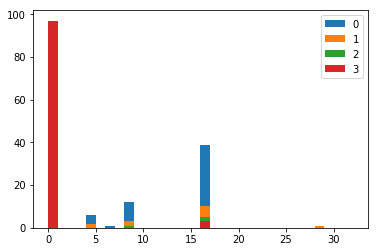

In [82]:
accuracy=5
experiments=100
%matplotlib inline
import matplotlib.pyplot as plt
for j in range(0,4,1):
    out=[]
    for i in range(experiments):
        out.append(QPE(M,accuracy=accuracy,vector=j,cheat=False))
    x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),label="%s"%j)
plt.legend()
plt.show()
plt.close()


For the vector=4, 

$b=|01>=\frac{\sqrt{2}}{2}(|v_1>-|v_2>)$

so, because this superposition, the final state after the QPE must contain eigenvalues $\lambda_1$ and $\lambda_2$

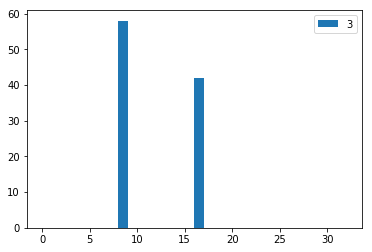

In [59]:
out=[]
j=4
for i in range(experiments):
    out.append(QPE(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),label="%s"%j)
plt.legend()
plt.show()
plt.close()

For the vector=5, 

$b=|10>=\frac{\sqrt{2}}{2}(|v_3>-|v_4>)$

so, because this superposition, the final state after the QPE must contain eigenvalues $\lambda_3$ and $\lambda_4$

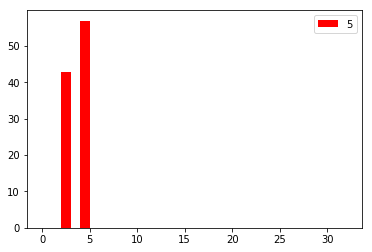

In [79]:
out=[]
j=5
for i in range(experiments):
    out.append(QPE(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),color="r",label="%s"%j)
plt.legend()
plt.show()
plt.close()

And, because 
$$|b>=H_1 R_{x0}(0.05)R_{x1}(0.25)|00> = \sum_{i=1}^4\beta_i |v_i>$$

the final state must have a combination of every eigenvalue

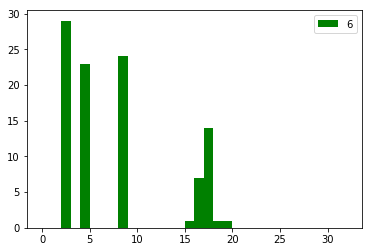

In [80]:
out=[]
j=6
for i in range(experiments):
    out.append(QPE(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),color="g",label="%s"%j)
plt.legend()
plt.show()
plt.close()

In [ ]:
import numpy as np
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import MatrixOperator, WeightedPauliOperator, op_converter
from qiskit.aqua.utils import decimal_to_binary
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.algorithms import QPE
from qiskit.aqua.components.iqfts import Standard
from qiskit.aqua.components.initial_states import Custom

In [ ]:
Mqiskit = MatrixOperator(matrix=M)
Mqiskit = op_converter.to_weighted_pauli_operator(Mqiskit)
Mqiskit.to_dict()

In [ ]:
tmp_qubit_op = Mqiskit.copy()
exact_eigensolver = ExactEigensolver(tmp_qubit_op,k=2**Mqiskit.num_qubits)
results = exact_eigensolver.run()

#print(results)
ref_eigenval = results['eigvals']
ref_eigenvec = results['eigvecs']
print('The exact eigenvalue is:       %s', ref_eigenval[2])
print('The corresponding eigenvector: %s', ref_eigenvec[2])


In [ ]:
accuracy=5
vector=Mqiskit.num_qubits
state_in = Custom(vector, state_vector=ref_eigenvec[2])
iqft = Standard(accuracy)


In [ ]:
num_time_slices=1
qpe = QPE(Mqiskit, state_in, iqft, num_time_slices, accuracy,
          expansion_mode='trotter', expansion_order=2,
          shallow_circuit_concat=True)


In [ ]:
backend = BasicAer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, shots=1000)



In [ ]:

circuit=qpe.construct_circuit(measurement=True)
result = quantum_instance.execute(circuit)


In [ ]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(result.get_counts())

In [ ]:
print(result.get_counts())

In [ ]:
from qiskit.aqua.algorithms import HHL, ExactLSsolver
from qiskit.aqua.utils import random_matrix_generator as rmg
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation, LongDivision
from qiskit.aqua.components.qfts import Standard as StandardQFTS
from qiskit.aqua.components.iqfts import Standard as StandardIQFTS
from qiskit.aqua.components.initial_states import Custom

In [ ]:
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(M, ChiP)

In [ ]:
matrix

In [ ]:
vector

In [ ]:
init_state = Custom(2, state_vector=vector)

In [ ]:
ne_qfts = [None, None]
negative_evals=False

eigs=EigsQPE(MatrixOperator(matrix=matrix),
                       StandardIQFTS(3),
                       num_time_slices=1,
                       num_ancillae=5,
                       expansion_mode='suzuki',
                       expansion_order=2,
                       evo_time=None,
                       negative_evals=False,
                       ne_qfts=ne_qfts)

num_q, num_a = eigs.get_register_sizes()
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

In [ ]:
algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
                   init_state, reci, num_q, num_a, len(vector))
hhl_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                              seed_simulator=1,
                                              seed_transpiler=1))

hhl_solution = hhl_result['solution']
hhl_normed = hhl_solution/np.linalg.norm(hhl_solution)

In [ ]:
hhl_result

In [ ]:
hhl_solution

In [ ]:
hhl_normed